# Lab 02 Action Learning - Validación, optimización y selección de modelos

## Introducción

La validación, optimización y selección de modelos son tres temas estrechamente relacionados en Machine Learning (ML) que no deben ser pasados por alto en ningún proyecto que exija una mínima calidad predictiva.

**Validación**

La validación de modelos se refiere al proceso de evaluar un modelo de ML para determinar su rendimiento a la hora de hacer predicciones en nuevos datos. La validación se realiza utilizando un conjunto de datos de prueba que no se ha utilizado en el proceso de entrenamiento. Los dos métodos comunes de validación de modelos incluyen el uso de un conjunto de validación y la validación cruzada. 

**Optimización**

La optimización de modelos se refiere al proceso de ajustar los hiperparámetros de un modelo para que pueda hacer predicciones más precisas. Existen diferentes métodos de optimización, como Grid Search y Random Search.

**Selección**

La selección de modelos se refiere al proceso de seleccionar el mejor modelo para un problema de ML en particular. En general, si se compara un conjunto de modelos, la selección atiende a un criterio de puro rendimiento predictivo. No obstante, y dependiendo del caso de uso, se pueden utilizar otros criterios de selección, como la relación entre la complejidad del modelo y su rendimiento, o la capacidad del modelo para ser explicado (interpretabilidad). Es posible incluso combinar varios modelos mediante un **ensembling**.


En resumen, la validación es necesaria para evaluar la capacidad de generalización del modelo, la optimización es necesaria para ajustar los hiperparámetros del modelo para mejorar su precisión, y la selección de modelos se utiliza para elegir el mejor modelo para un problema de machine learning en particular. Estas tres fases son fundamentales a la hora de obtener el mejor modelo posible. Vamos a ver cómo realizarlas con Python, utilizando el problema del Titanic que ya conocemos.

0. [Modelización básica](#seccion0)  
1. [Validación cruzada](#seccion1)     
2. [Optimización de hiperparámetros](#seccion2)
3. [Algoritmos de ensembling](#seccion3)
4. [Selección del mejor modelo](#seccion4) 

<a id='seccion0'></a>
## 0. Modelización básica

In [1]:
import pandas as pd

# Cargamos datos de entrenamiento 
df = pd.read_csv("titanic_data.csv")
target_col = 'Survived'

# Conversión de tipos
df['PassengerId'] = df.PassengerId.astype('object')
df['Pclass'] = df.Pclass.astype('object')

# Imputación de nulos
df[['Embarked', 'Cabin']] = df[['Embarked', 'Cabin']].fillna('UNKNOWN')  
df['Age'] = df['Age'].fillna(-1)

# Feature engineering
df["CabinFloor"] = df["Cabin"].apply(lambda cabin: cabin.split(" ")[0][0] if cabin != 'UNKNOWN' else cabin) 
df["Title"] = df["Name"].apply(lambda name: name.split(",")[1].split(".")[0].strip())

# Eliminamos columnas 
df.drop(columns = ['Ticket', 'Name', 'Cabin'], inplace = True)

# Categorical encoding
df = pd.get_dummies(df, columns = ['Pclass', 'Sex', 'Embarked', 'CabinFloor', 'Title'])
print(df.shape)
df.head()

(891, 41)


/var/folders/wj/9fw1vkvd1216xmhwx144yvmh0000gn/T/ipykernel_82156/3899243131.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns = ['Pclass', 'Sex', 'Embarked', 'CabinFloor', 'Title'])


,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,1,0,22.0,1,0,7.2500,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,2,1,38.0,1,0,71.2833,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
3,4,1,35.0,1,0,53.1000,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,0,35.0,0,0,8.0500,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['PassengerId', 'Survived']) # Matriz de inputs
y = df[target_col]

# Validación hold-out: partición en train/test con un porcentaje de test del 33%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 123)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 

# Instanciación del modelo
clf = DecisionTreeClassifier(max_depth = 10) 

# Entrenamiento del modelo
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [4]:
# Obtención de probabilidades 
y_prob = clf.predict_proba(X_test)[:, 1]

# ROC AUC de test
print(metrics.roc_auc_score(y_test, y_prob).round(2))

0.78


<a id='seccion1'></a>
## 1. Validación cruzada

La validación cruzada (cross-validation) es un método más robusto para evaluar el rendimiento de un modelo de Machine Learning respecto del uso de un conjunto de validación (hold-out).

Como sabemos, en la validación hold-out se divide el conjunto de datos en dos partes: un conjunto de entrenamiento y un conjunto de validación. El modelo se entrena en el conjunto de entrenamiento y se evalúa en el conjunto de validación. Esta evaluación proporciona una medida o estimación del rendimiento predictivo del modelo frente a datos no utilizados para entrenarlo; es decir, su capacidad de generalización.

Por otro lado, la validación cruzada implica dividir el conjunto de datos en K particiones (folds). Luego, se realizan K iteraciones, en cada una de las cuales se utiliza una partición diferente como conjunto de validación, y las otras K-1 particiones se usan como conjunto de entrenamiento. Después de cada iteración, se registra el rendimiento del modelo en el conjunto de validación, y finalmente se obtiene una estimación del rendimiento predictivo utilizando el promedio sobre las K iteraciones.

<img src="https://miro.medium.com/max/1009/1*1RPHQk-xpKMInxkEd1qFyg.png" alt="drawing" width="1000" height="500"/>

La principal diferencia entre los dos métodos es que la validación cruzada utiliza todos los datos para entrenar y evaluar el modelo, mientras que la validación hold-out sólo utiliza una parte de los datos para la evaluación. Por tanto, la validación cruzada es más robusta y proporciona una medida más precisa del rendimiento del modelo, especialmente cuando el conjunto de datos es pequeño y/o los datos son muy variables. Por otro lado, la evaluación con un conjunto de validación puede ser más fácil y rápida de implementar, especialmente cuando el conjunto de datos es grande.

Para entender la utilidad de la validación cruzada, observemos como varía el rendimiento estimado del modelo en función del conjunto de validación escogido:


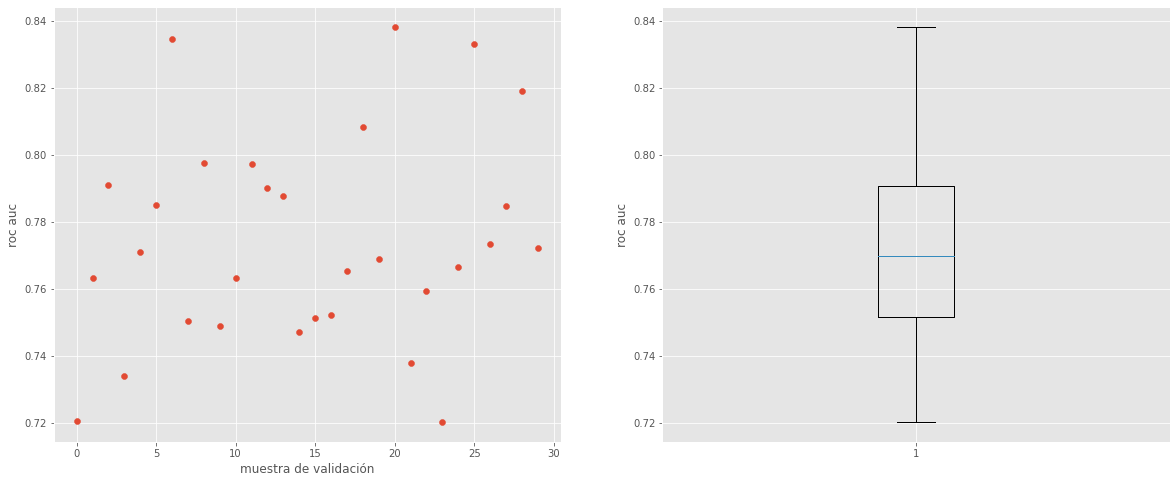

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 8] 

roc_auc = list()
n_iters = 30
for i in range(n_iters):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)
    clf = DecisionTreeClassifier(max_depth = 10) 
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    roc_auc.append(metrics.roc_auc_score(y_test, y_prob))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(range(n_iters), roc_auc)
ax1.set_xlabel("muestra de validación")
ax1.set_ylabel("roc auc")
ax2.boxplot(roc_auc)
ax2.set_ylabel("roc auc")
plt.show()    

Observamos que seleccionado aleatoriamente uno u otro conjunto de validación, el rendimiento predictivo estimado del modelo puede llegar a variar en un rango de un 10% (¡lo cual es mucho!). Parece lógico, por tanto, no utilizar solo un conjunto de validación, sino utilizar varios, para obtener una evaluación robusta del modelo (con una media). Esto es precisamente lo que vamos a hacer con la validación cruzada, que permite validar un modelo usando todo el cojunto de datos mediante K particiones.

### 1.1 K-Fold Cross-Validation

In [8]:
from sklearn.model_selection import cross_val_score # Importamos función de validación cruzada

cv_results = cross_val_score(
    clf, # Modelo
    X, # Inputs
    y, # Target
    cv = 5, # Número de iteraciones de validación cruzada
    scoring = 'roc_auc', # Métrica de scoring
    n_jobs = -1, # Número de procesos paralelos (-1 usa todos los procesadores)
)

cv_results

array([0.79499341, 0.79819519, 0.8572861 , 0.76076203, 0.82528919])

In [9]:
print("Resultados para cada iteración de CV:\n")
print("Iteración| Score")
print("------------------")
for i, cv_result in enumerate(cv_results):
    print('   ', i+1, '   |',round(cv_result, 4))
    
import numpy as np
print("\nResumen:", np.round(np.mean(cv_results), 4), "\u00B1", np.round(np.std(cv_results), 4))

Resultados para cada iteración de CV:

Iteración| Score
------------------
    1    | 0.795
    2    | 0.7982
    3    | 0.8573
    4    | 0.7608
    5    | 0.8253

Resumen: 0.8073 ± 0.0323


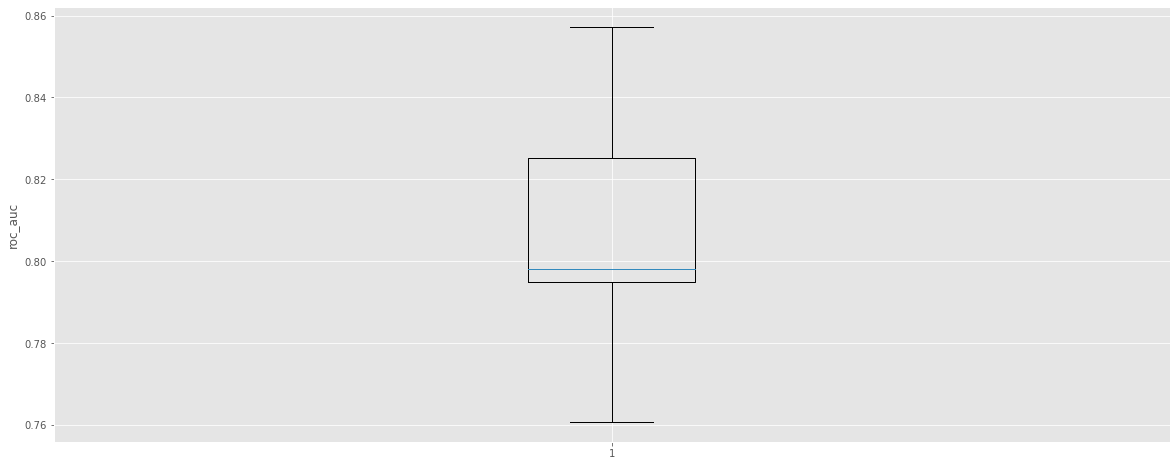

In [10]:
plt.boxplot(cv_results)
plt.ylabel("roc_auc")
plt.show()

### 1.2 Repeated K-Fold Cross-Validation

En general, con el K-Fold Cross Validation podemos estar seguros de obtener una buena estimación del rendimiento del modelo. Sin embargo, podemos ir un paso más allá y repetirlo N veces (con particiones distintas cada vez), para obtener así una evaluación todavía más robusta del modelo. 

In [11]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(
    n_splits=5, # Número de particiones de CV 
    n_repeats=5 # Númro de repeticiones de CV
)

cv_results = cross_validate(
    clf,
    X,
    y,
    cv = cv, # Objeto CV definido arriba
    scoring = 'roc_auc', 
    n_jobs = -1,
)

cv_results

{'fit_time': array([0.006078  , 0.00541282, 0.00593901, 0.00611115, 0.00724006,
        0.00510597, 0.00786114, 0.00822115, 0.00823879, 0.00943685,
        0.00911999, 0.00601721, 0.00748515, 0.00692773, 0.00758719,
        0.00810385, 0.02850223, 0.01142812, 0.02331209, 0.00822878,
        0.00781798, 0.01549721, 0.00723505, 0.00808001, 0.00764394]),
 'score_time': array([0.00294995, 0.00400615, 0.00372219, 0.00445795, 0.00600219,
        0.00298619, 0.01261401, 0.01205301, 0.00900817, 0.01185322,
        0.01080585, 0.00536585, 0.00623178, 0.01002216, 0.03059292,
        0.01350617, 0.0053668 , 0.00590491, 0.00676203, 0.01097202,
        0.00534511, 0.00931096, 0.00570083, 0.00504899, 0.00514102]),
 'test_score': array([0.75993641, 0.77401245, 0.77598494, 0.78167797, 0.8110587 ,
        0.7819135 , 0.75909563, 0.81756297, 0.81696429, 0.78620411,
        0.71154891, 0.76071429, 0.77463103, 0.80683164, 0.79826203,
        0.786173  , 0.7727031 , 0.79484671, 0.7046131 , 0.78810307,
    

In [12]:
print("Resultados para cada iteración de CV:\n")
print("Iteración| Score")
print("------------------")
for i, cv_result in enumerate(cv_results['test_score']):
    print('   ', str(i+1).rjust(2, '0'), '   |',round(cv_result, 4))

print("\nResumen:", np.round(np.mean(cv_results['test_score']), 4), "\u00B1", np.round(np.std(cv_results['test_score']), 4))

Resultados para cada iteración de CV:

Iteración| Score
------------------
    01    | 0.7599
    02    | 0.774
    03    | 0.776
    04    | 0.7817
    05    | 0.8111
    06    | 0.7819
    07    | 0.7591
    08    | 0.8176
    09    | 0.817
    10    | 0.7862
    11    | 0.7115
    12    | 0.7607
    13    | 0.7746
    14    | 0.8068
    15    | 0.7983
    16    | 0.7862
    17    | 0.7727
    18    | 0.7948
    19    | 0.7046
    20    | 0.7881
    21    | 0.8117
    22    | 0.8117
    23    | 0.7926
    24    | 0.7858
    25    | 0.8279

Resumen: 0.7837 ± 0.029


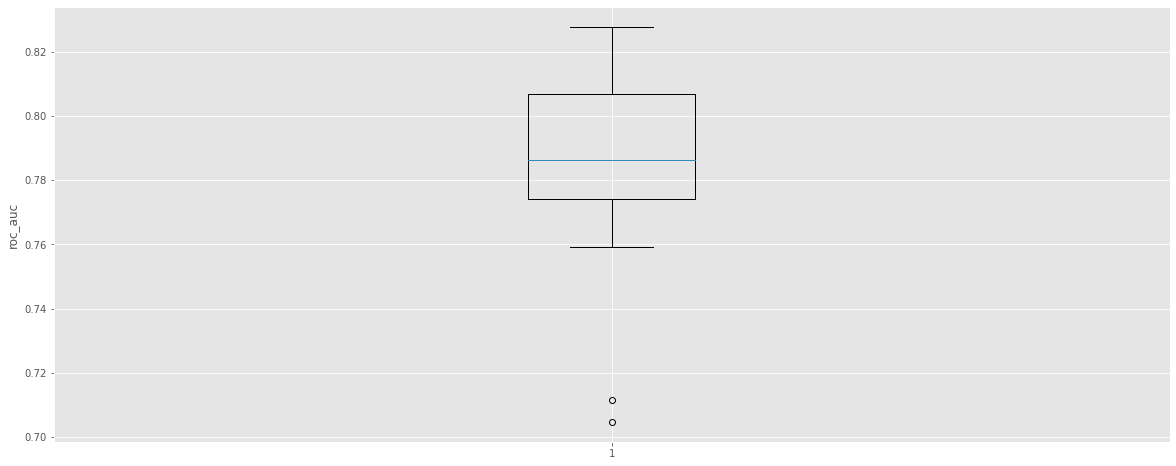

In [13]:
plt.boxplot(cv_results['test_score'])
plt.ylabel("roc_auc")
plt.show()

### 1.3 Leave-One-Out Cross-Validation

El caso más extremo de validación cruzada es dividir el conjunto de datos en tantas particiones como observaciones tenga (supongamos N), entrenar un modelo con N-1 observaciones y validarlo con la observación restante, lo cual se podrá hacer N veces.

In [14]:
from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()

cv_results = cross_validate(
    clf,
    X,
    y,
    cv = cv,
    scoring = 'accuracy', 
    n_jobs = -1,
)

In [15]:
print("Resultados para cada iteración de CV:\n")
print("Iteración|Score")
print("------------------")
for i, cv_result in enumerate(cv_results['test_score']):
    print('   ', str(i+1).rjust(2, '0'), '   |',round(cv_result, 4))

print("\nResumen:", np.round(np.mean(cv_results['test_score']), 4))

Resultados para cada iteración de CV:

Iteración|Score
------------------
    01    | 1.0
    02    | 1.0
    03    | 0.0
    04    | 1.0
    05    | 1.0
    06    | 1.0
    07    | 1.0
    08    | 1.0
    09    | 1.0
    10    | 1.0
    11    | 1.0
    12    | 0.0
    13    | 1.0
    14    | 1.0
    15    | 0.0
    16    | 1.0
    17    | 1.0
    18    | 0.0
    19    | 1.0
    20    | 1.0
    21    | 1.0
    22    | 0.0
    23    | 1.0
    24    | 0.0
    25    | 1.0
    26    | 0.0
    27    | 1.0
    28    | 1.0
    29    | 1.0
    30    | 1.0
    31    | 0.0
    32    | 1.0
    33    | 1.0
    34    | 1.0
    35    | 1.0
    36    | 1.0
    37    | 0.0
    38    | 1.0
    39    | 1.0
    40    | 1.0
    41    | 1.0
    42    | 0.0
    43    | 1.0
    44    | 0.0
    45    | 0.0
    46    | 1.0
    47    | 1.0
    48    | 1.0
    49    | 1.0
    50    | 1.0
    51    | 1.0
    52    | 1.0
    53    | 1.0
    54    | 1.0
    55    | 1.0
    56    | 0.0
    57    | 1.0
    58    | 1.

    806    | 0.0
    807    | 1.0
    808    | 0.0
    809    | 1.0
    810    | 1.0
    811    | 1.0
    812    | 1.0
    813    | 1.0
    814    | 1.0
    815    | 1.0
    816    | 1.0
    817    | 0.0
    818    | 1.0
    819    | 1.0
    820    | 1.0
    821    | 1.0
    822    | 0.0
    823    | 0.0
    824    | 0.0
    825    | 1.0
    826    | 1.0
    827    | 0.0
    828    | 1.0
    829    | 0.0
    830    | 1.0
    831    | 0.0
    832    | 1.0
    833    | 1.0
    834    | 1.0
    835    | 1.0
    836    | 1.0
    837    | 1.0
    838    | 1.0
    839    | 1.0
    840    | 1.0
    841    | 1.0
    842    | 1.0
    843    | 1.0
    844    | 1.0
    845    | 1.0
    846    | 1.0
    847    | 1.0
    848    | 1.0
    849    | 0.0
    850    | 1.0
    851    | 1.0
    852    | 1.0
    853    | 1.0
    854    | 1.0
    855    | 0.0
    856    | 0.0
    857    | 1.0
    858    | 1.0
    859    | 0.0
    860    | 1.0
    861    | 1.0
    862    | 1.0
    863    | 1.0
    864    | 1

<a id='seccion2'></a>
## 2. Optimización de hiperparámetros 

La optimización de hiperparámetros es una técnica para encontrar la combinación óptima de valores para los hiperparámetros de un modelo. Los hiperparámetros son valores que se establecen antes de entrenar el modelo y que afectan el rendimiento del modelo. Ejemplos de hiperparámetros pueden ser la tasa de aprendizaje (learning rate), la profundidad de un árbol de decisión, el número de capas ocultas en una red neuronal, etc.

El objetivo de la optimización de hiperparámetros es encontrar la combinación de valores de hiperparámetros que maximice la precisión del modelo o minimice el coste. Hay varios métodos para optimizar hiperparámetros, de los cuales vamos a ver:

- **Grid Search**: se especifica una lista de valores posibles para cada hiperparámetro y se busca exhaustivamente en todas las combinaciones posibles. Es decir, se evalúan todas las combinaciones de valores posibles de hiperparámetros. Este método es útil si el espacio de búsqueda es relativamente pequeño.

- **Random Search**: los hiperparámetros se seleccionan al azar dentro de un rango de valores predefinido. Este método es más eficiente que Grid Search en términos de tiempo de ejecución y puede encontrar combinaciones óptimas de hiperparámetros con menos evaluaciones de modelos.



<img src="https://miro.medium.com/max/1004/0*yDmmJmvRowl0cSN8.png" alt="drawing" width="1000" height="500"/>

La evaluación del rendimiento de un modelo con diferentes combinaciones de hiperparámetros se suele realizar mediante validación cruada. Así, la combinación óptima de hiperparámetros será aquella que maximice la métrica obtenida con validación cruzada.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="drawing" width="800" height="500"/>

In [17]:
# Instanciamos modelo vacío
clf = DecisionTreeClassifier()

# Hiperparámetros disponibles
clf.get_params() # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### 2.1 Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV

# Definimos número de iteraciones de validación cruzada
cv_iter = 5

# Definimos malla (grid) de hiperparámetros
param_grid = {
    'max_depth': np.arange(4, 21, 2), # igual a [ 4,  6,  8, 10, 12, 14, 16, 18, 20]
    'max_features': np.arange(4, 21, 2)
}

# Instanciamos objeto de grid search
clf_grid_search = GridSearchCV(
    estimator = clf, 
    param_grid = param_grid, 
    cv = cv_iter,
    scoring = 'roc_auc', 
    n_jobs = -1,
    verbose = 1
)

# Lo ejecutamos
clf_grid_search.fit(X, y)
clf_grid_search

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 4,  6,  8, 10, 12, 14, 16, 18, 20]),
                         'max_features': array([ 4,  6,  8, 10, 12, 14, 16, 18, 20])},
             scoring='roc_auc', verbose=1)

In [19]:
print("Mejor score:", np.round(clf_grid_search.best_score_, 4))
print("Hiperparámetros asociados:", clf_grid_search.best_params_)

# Mejor estimador
clf_grid_search.best_estimator_

Mejor score: 0.8583
Hiperparámetros asociados: {'max_depth': 6, 'max_features': 16}


DecisionTreeClassifier(max_depth=6, max_features=16)

In [20]:
# Todos los resultados 
df_grid_search_results = pd.DataFrame(clf_grid_search.cv_results_)
print(df_grid_search_results.shape)
df_grid_search_results.head()

(81, 15)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004732,0.001452,0.004411,0.001201,4,4,"{'max_depth': 4, 'max_features': 4}",0.773781,0.823730,0.840374,0.832286,0.808736,0.815781,0.023469,24
1,0.006079,0.000152,0.009074,0.002044,4,6,"{'max_depth': 4, 'max_features': 6}",0.792227,0.792981,0.772393,0.805882,0.818109,0.796319,0.015275,32
2,0.012690,0.006059,0.007399,0.003002,4,8,"{'max_depth': 4, 'max_features': 8}",0.847431,0.822259,0.847995,0.844184,0.852879,0.842950,0.010712,10
3,0.007223,0.001144,0.007830,0.002442,4,10,"{'max_depth': 4, 'max_features': 10}",0.814888,0.811029,0.883489,0.840775,0.909055,0.851847,0.038545,4
4,0.008849,0.006350,0.010186,0.003078,4,12,"{'max_depth': 4, 'max_features': 12}",0.838011,0.814238,0.860561,0.834559,0.890507,0.847575,0.026015,8


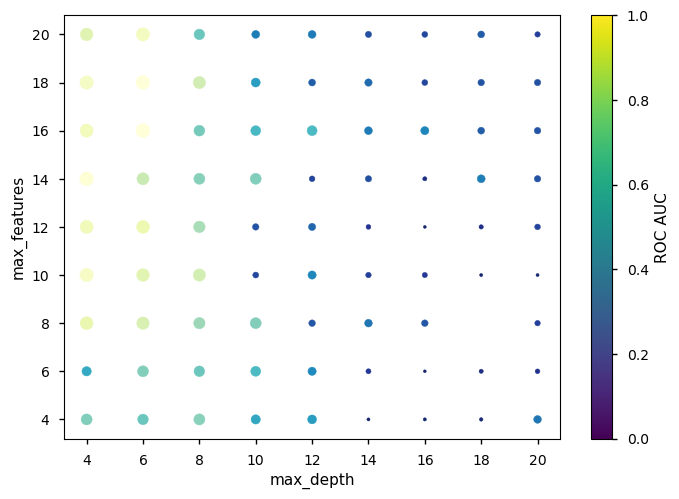

In [21]:
import matplotlib as mpl

mpl.rcdefaults()
plt.style.use('seaborn-notebook')

param_1 = 'max_depth'
param_2 = 'max_features'

param_1_values = df_grid_search_results[f"param_{param_1}"]
param_2_values = df_grid_search_results[f"param_{param_2}"]
mean_test_scores = df_grid_search_results["mean_test_score"]

values = (mean_test_scores - min(mean_test_scores)) / (max(mean_test_scores) - min(mean_test_scores))
colors = plt.cm.YlGnBu(1 - values)
plt.scatter(
    x = param_1_values, 
    y = param_2_values, 
    s = 100 * values,
    c = colors
)
barra_colores = plt.colorbar()
barra_colores.set_label('ROC AUC')
plt.xlabel(param_1)
plt.ylabel(param_2)
plt.show()

### 2.2 Random Search

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Definimos número de iteraciones de validación cruzada
cv_iter = 5

# Definimos distribuciones de hiperparámetros
param_distributions = {
    'max_depth': randint(2, 15), 
    'max_features': randint(2, 30)
}

# Instanciamos objeto de grid search
clf_random_search = RandomizedSearchCV(
    estimator = clf, 
    param_distributions = param_distributions, 
    n_iter = 100,
    cv = cv_iter,
    scoring = 'roc_auc', 
    n_jobs = -1,
    verbose = 1
)

# Lo ejecutamos
clf_random_search.fit(X, y)
clf_random_search

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd35529b340>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd3553671f0>},
                   scoring='roc_auc', verbose=1)

In [23]:
print("Mejor score:", np.round(clf_random_search.best_score_, 4))
print("Hiperparámetros asociados:", clf_random_search.best_params_)

# Mejor estimador
clf_random_search.best_estimator_

Mejor score: 0.866
Hiperparámetros asociados: {'max_depth': 6, 'max_features': 12}


DecisionTreeClassifier(max_depth=6, max_features=12)

In [24]:
# Todos los resultados
df_random_search_results = pd.DataFrame(clf_random_search.cv_results_)
print(df_random_search_results.shape)
df_random_search_results.head()

(100, 15)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004360,0.001220,0.004736,0.000783,3,18,"{'max_depth': 3, 'max_features': 18}",0.881621,0.797393,0.863503,0.825401,0.861853,0.845954,0.030376,20
1,0.005724,0.001084,0.006441,0.000880,5,2,"{'max_depth': 5, 'max_features': 2}",0.805270,0.744385,0.841110,0.799666,0.704893,0.779065,0.048301,81
2,0.006621,0.000466,0.006088,0.000250,2,22,"{'max_depth': 2, 'max_features': 22}",0.816008,0.825334,0.804078,0.744786,0.855538,0.809149,0.036412,53
3,0.006230,0.000193,0.006702,0.000351,5,11,"{'max_depth': 5, 'max_features': 11}",0.808169,0.820521,0.877674,0.834626,0.915769,0.851352,0.039843,12
4,0.006115,0.000365,0.008131,0.001616,2,4,"{'max_depth': 2, 'max_features': 4}",0.792292,0.579746,0.735361,0.680147,0.718322,0.701174,0.070643,99


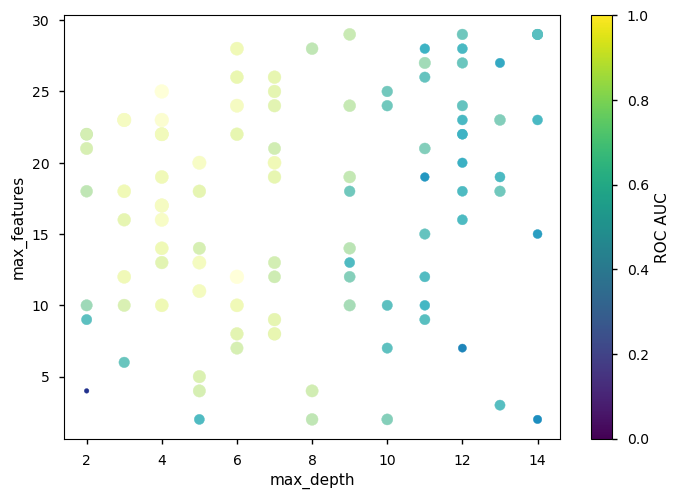

In [25]:
param_1 = 'max_depth'
param_2 = 'max_features'

param_1_values = df_random_search_results[f"param_{param_1}"]
param_2_values = df_random_search_results[f"param_{param_2}"]
mean_test_scores = df_random_search_results["mean_test_score"]

values = (mean_test_scores - min(mean_test_scores)) / (max(mean_test_scores) - min(mean_test_scores))
colors = plt.cm.YlGnBu(1 - values)
plt.scatter(
    x = param_1_values, 
    y = param_2_values, 
    s = 100 * values,
    c = colors
)
barra_colores = plt.colorbar()
barra_colores.set_label('ROC AUC')
plt.xlabel(param_1)
plt.ylabel(param_2)
plt.show()

<a id='seccion3'></a>
## 3. Algoritmos de ensembling

El ensembling es una técnica de ML que combina múltiples modelos para mejorar el rendimiento predictivo. En esencia, en lugar de confiar en un solo modelo, se construyen varios modelos y se combinan para hacer predicciones. Este enfoque es similar a tener un conjunto de expertos trabajando juntos en un problema para llegar a una solución consensuada. Cada modelo individual puede tener fortalezas y debilidades diferentes, pero en conjunto pueden proporcionar una solución más robusta y precisa.

Existen varios tipos de ensembling en Machine Learning, de los cuales los más utilizados son:

- **Bagging**: se entrenan varios modelos utilizando diferentes conjuntos de datos de entrenamiento, y luego se combinan las predicciones de los modelos individuales para producir una predicción final. Este enfoque funciona especialmente bien cuando se utilizan modelos de alta varianza, como los árboles de decisión.

- **Boosting**: se entrenan varios modelos débiles (es decir, modelos poco mejor que uno aleatorio) y se combinan para formar un modelo más fuerte. En lugar de promediar las predicciones de los modelos individuales, se utiliza un algoritmo de boosting para ajustar los pesos de los modelos individuales y mejorar su precisión.






<img src="https://pluralsight2.imgix.net/guides/81232a78-2e99-4ccc-ba8e-8cd873625fdf_2.jpg" alt="drawing" width="1000" height="500"/>

### 3.1 Bagging 

#### 3.1.1 Random Forest 

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Instanciación del modelo
clf = RandomForestClassifier() 

# Entrenamiento del modelo
clf.fit(X_train, y_train)

# Hiperparámetros del modelo
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

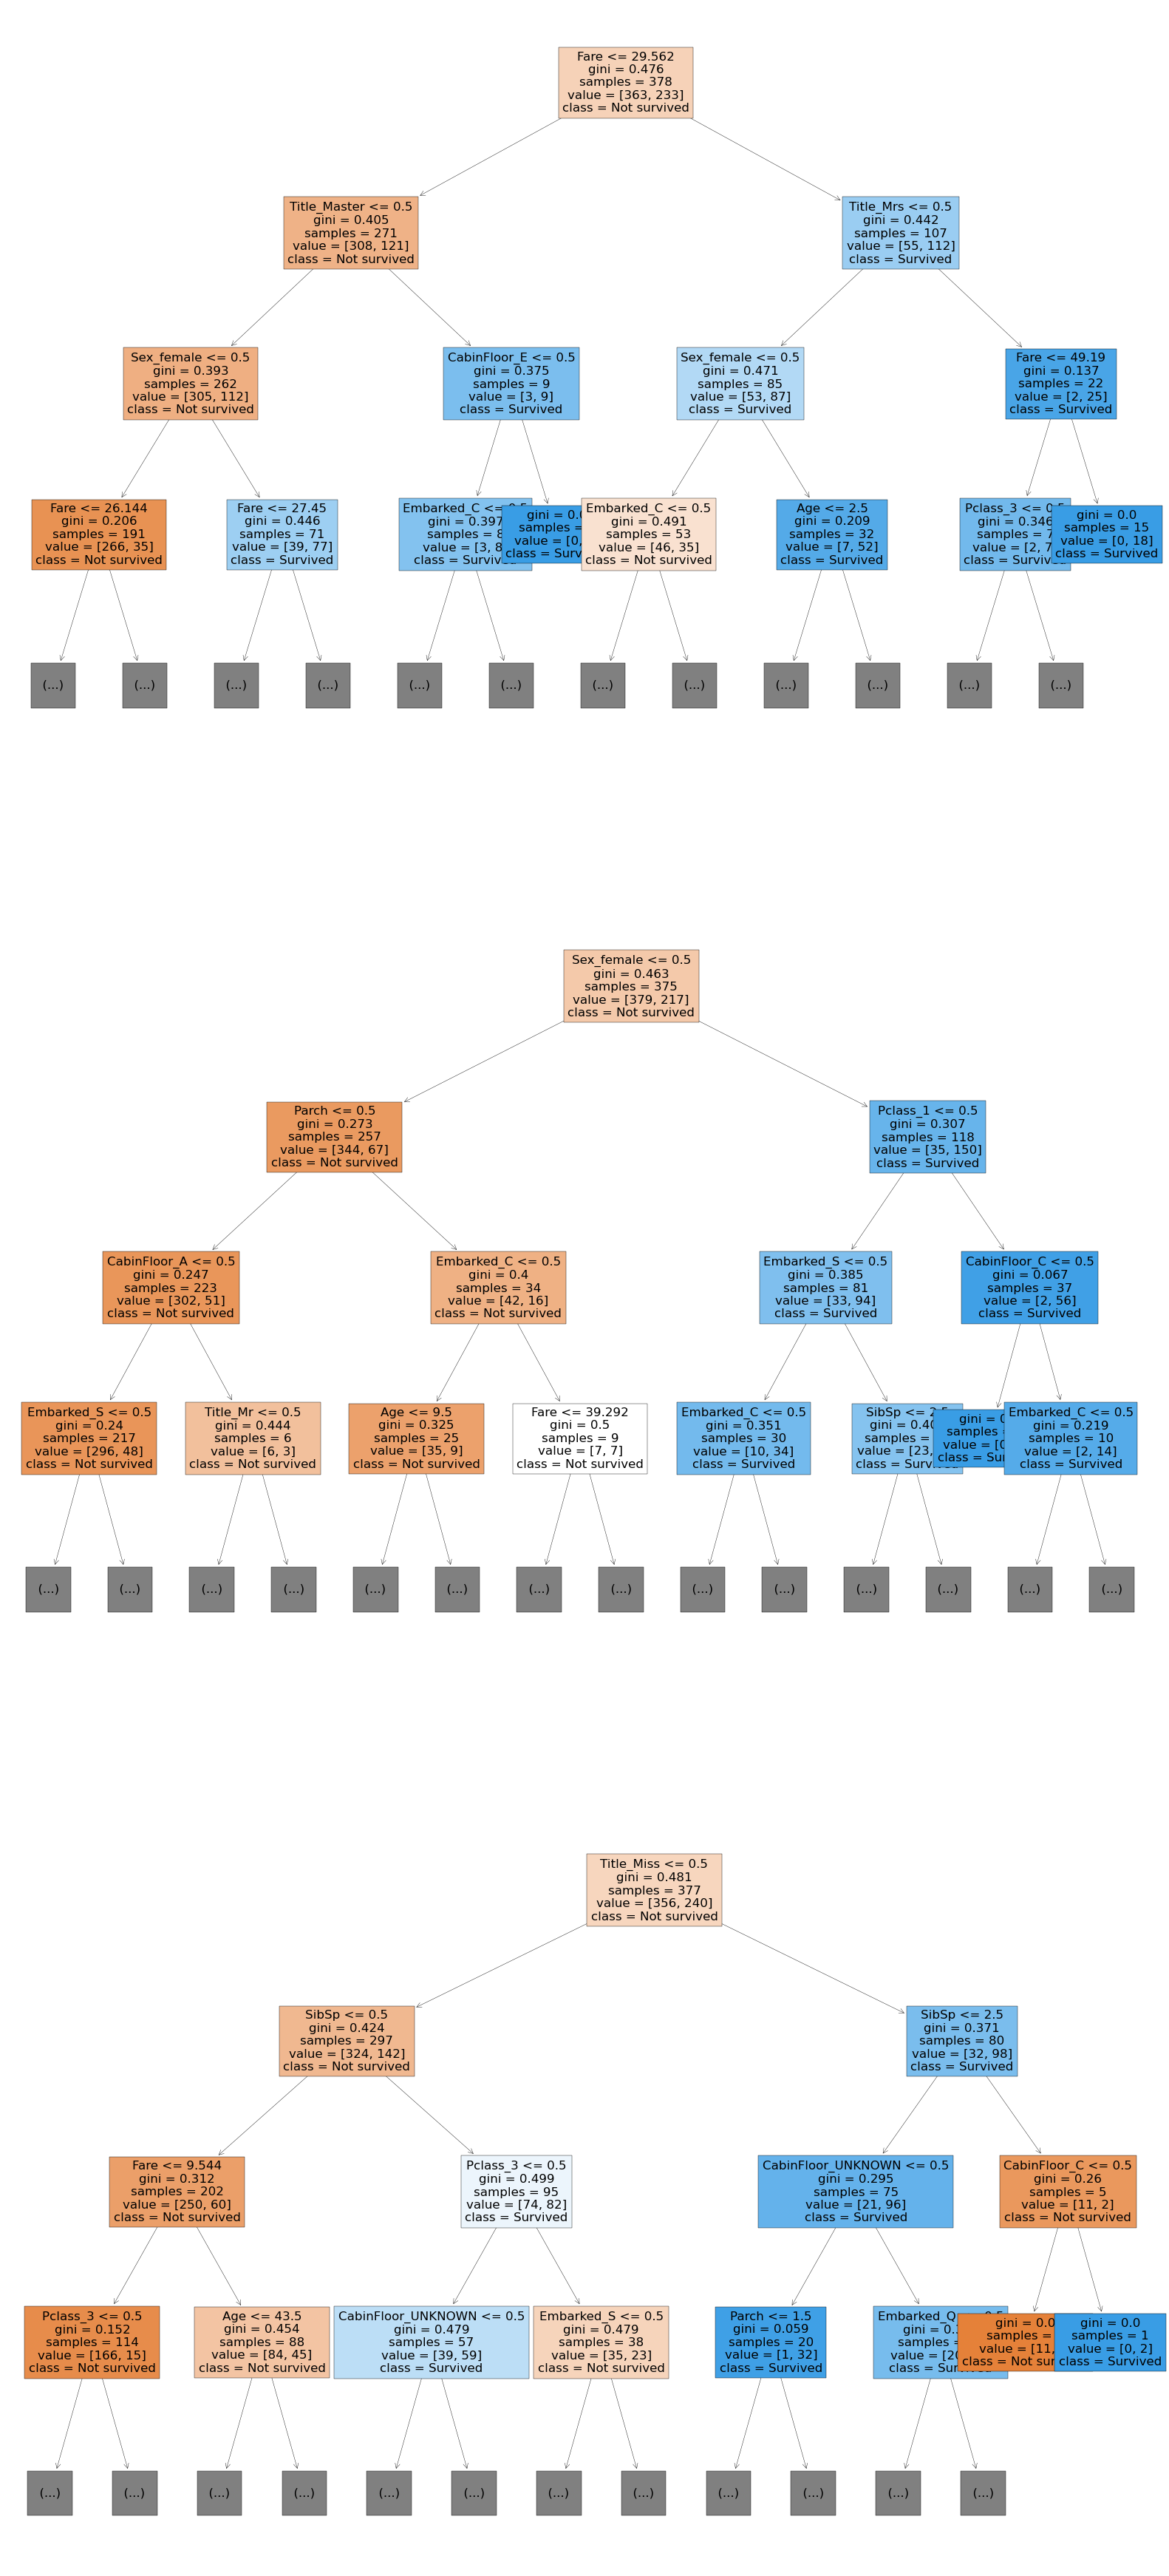

In [27]:
from sklearn.tree import plot_tree

# Visualización de algunos de los árboles de decisión 
trees = [4, 52, 99] # Valores entre 0 y n_estimators-1
n_axes = len(trees)

fig, axes = plt.subplots(n_axes, 1, figsize = (20, 15 * n_axes))
for i in range(len(axes)):
    plot_tree(
        clf.estimators_[trees[i]], 
        max_depth = 3, 
        filled = True, 
        class_names = ["Not survived", "Survived"],
        feature_names = X_train.columns,
        fontsize = 12, 
        ax = axes[i]
    )
plt.show()

In [28]:
# Predicciones
y_proba = clf.predict_proba(X_test)[:, 1]

# ROC AUC de test
print(metrics.roc_auc_score(y_test, y_proba).round(2))

0.86


### 3.2 Boosting

#### 3.2.1 AdaBoost

In [29]:
from sklearn.ensemble import AdaBoostClassifier

# Instanciación del modelo
clf = AdaBoostClassifier() 

# Entrenamiento del modelo
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict_proba(X_test)[:, 1]

# ROC AUC de test
print(metrics.roc_auc_score(y_test, y_pred).round(2))

0.86


#### 3.2.2 Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# Instanciación del modelo
clf = GradientBoostingClassifier() 

# Entrenamiento del modelo
clf.fit(X_train, y_train)

clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [31]:
# Predicciones
y_proba = clf.predict_proba(X_test)[:, 1]

# ROC AUC de test
print(metrics.roc_auc_score(y_test, y_proba).round(2))

0.87


#### 3.2.3 XGBoost

In [32]:
import xgboost as xgb
from xgboost import XGBClassifier

# Instanciación del modelo
clf = XGBClassifier() 

# Entrenamiento del modelo
clf.fit(X_train, y_train)

clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [33]:
# Predicciones
y_proba = clf.predict_proba(X_test)[:, 1]

# ROC AUC de test
print(metrics.roc_auc_score(y_test, y_proba).round(2))

0.87


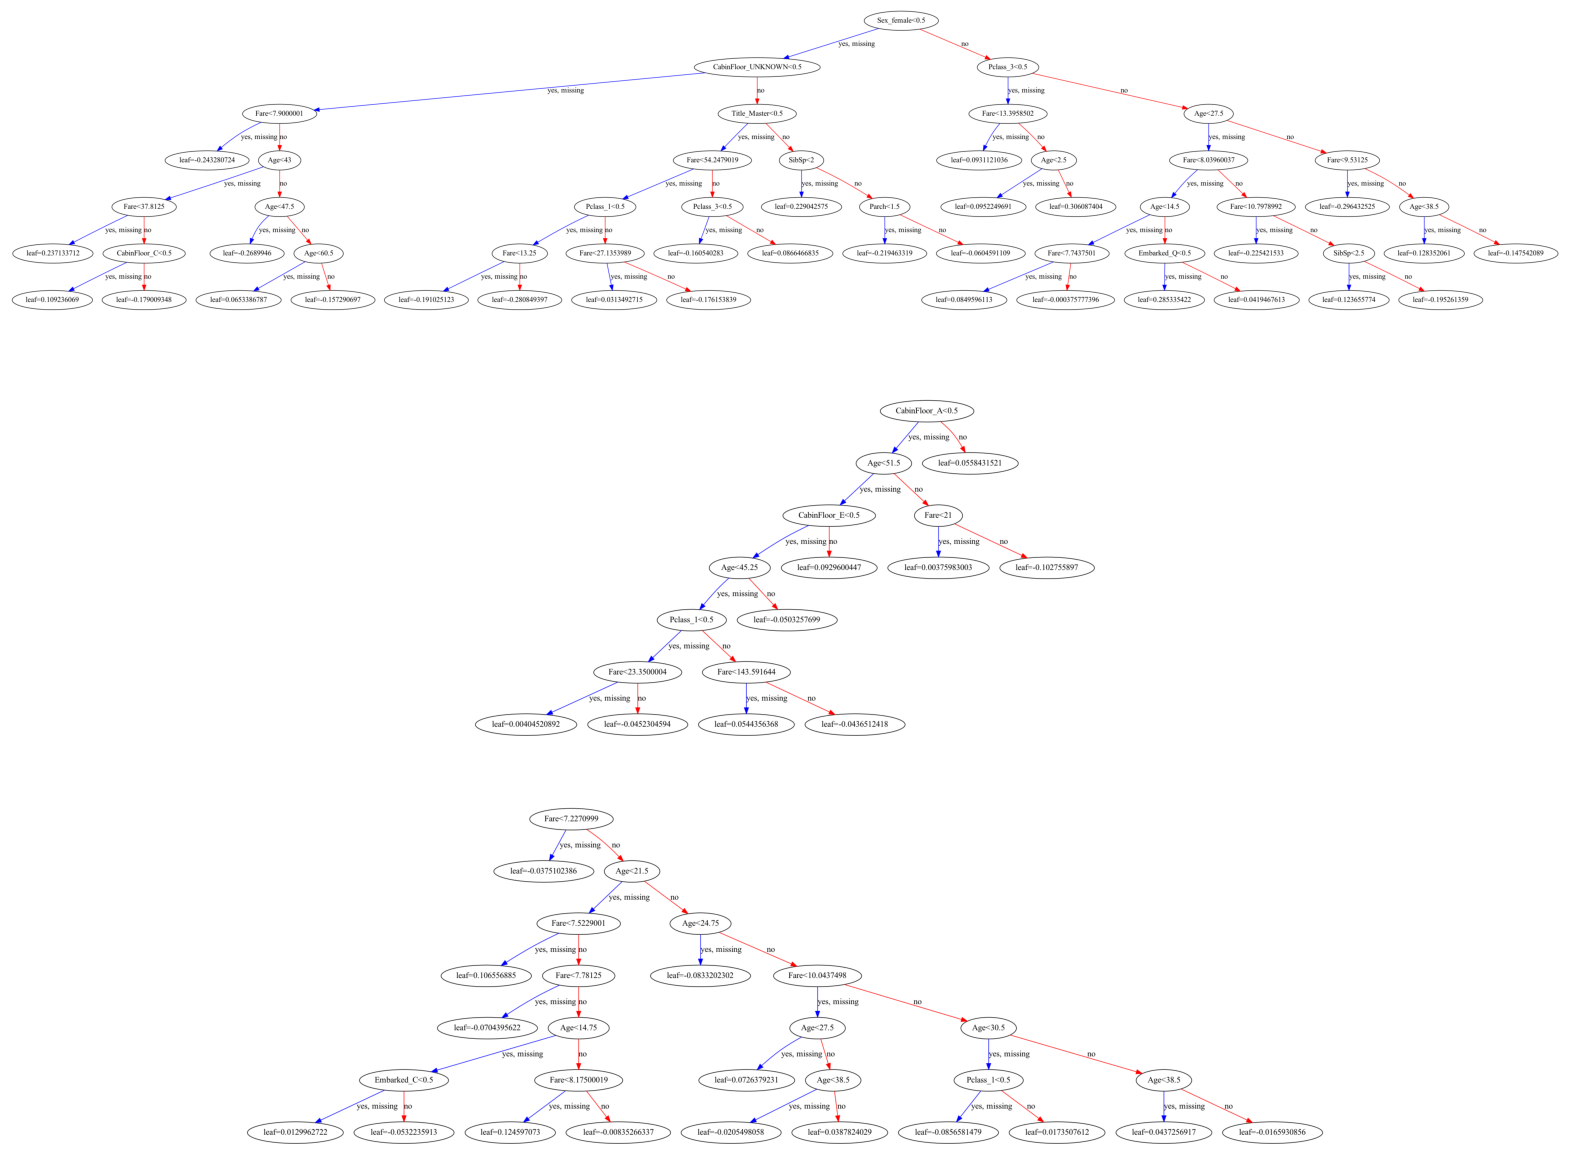

In [34]:
from sklearn.tree import plot_tree

# Visualización de algunos de los árboles de decisión 
trees = [4, 52, 99] # Valores entre 0 y n_estimators-1
n_axes = len(trees)

fig, axes = plt.subplots(n_axes, 1, figsize = (20, 5 * n_axes))
for i in range(len(axes)):
    xgb.plot_tree(
        clf, 
        num_trees=trees[i], 
        ax = axes[i]
    )
plt.show()

<a id='seccion4'></a>
## 4. Selección del mejor modelo

Vamos a implementar la optimización de hiperparámetros mediante validación cruzada para todos los modelos, para posteriormente seleccionar aquel con mejor rendimiento predictivo.

In [35]:
# Instanciamos los modelos y los almacenamos en un diccionario
# junto con los hiperparámetros que queramos optimizar 
classifiers = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(), 
        'hiperparameters': {
            'criterion': ["gini", "entropy"],
            'max_depth': randint(2, 10),
            'min_samples_leaf': randint(1, 5)
        } # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    },
    'RandomForest': {
        'model': RandomForestClassifier(n_jobs = -1), 
        'hiperparameters': {
          'criterion': ["gini", "entropy"],
          'max_depth': randint(2, 10),
          'min_samples_leaf': randint(1, 5),
          'n_estimators': randint(10, 100)
        } # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    }, 
    'GradientBoosting': {
        'model': GradientBoostingClassifier(), 
        'hiperparameters': {
          'max_depth': randint(2, 10),
          'min_samples_leaf': randint(1, 5),
          'learning_rate': [0.2, 0.1, 0.01],
          'n_estimators': randint(10, 100)
        } # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    },
    'XGBoost': {
        'model': XGBClassifier(objective = 'binary:logistic', n_jobs = -1), 
        'hiperparameters': {
          'max_depth': randint(2, 5),
          'n_estimators': randint(10, 100),
          'learning_rate': [0.2, 0.1, 0.01],
          'subsample': uniform(0.8, 0.2)
        } # https://xgboost.readthedocs.io/en/stable/parameter.html
    }
}

In [38]:
# Iteramos sobre el diccionario anterior, y mediante Random Search 
# vamos optimizando cada uno de los modelos y guardando los resultados
# en un pd.DataFrame
random_search_output = list()
best_estimators = {}
for clf_name, clf_info in classifiers.items():
    print(clf_name)
    clf_random_search = RandomizedSearchCV(
        estimator = clf_info['model'], 
        param_distributions = clf_info['hiperparameters'], 
        n_iter = 25,
        cv = 5,
        scoring = "roc_auc", 
        return_train_score = True,
        refit = True,
        n_jobs = -1,
        verbose = 3
    )
    clf_random_search.fit(X_train, y_train)
    # Resultados del Random Search
    df_output = pd.DataFrame(clf_random_search.cv_results_)
    df_output['clf'] = clf_name
    random_search_output.append(df_output)
    # Modelo re-entrenado con los hiperparámetros óptimos
    best_estimators[clf_name] = clf_random_search.best_estimator_

DecisionTree
Fitting 5 folds for each of 25 candidates, totalling 125 fits
RandomForest
Fitting 5 folds for each of 25 candidates, totalling 125 fits
GradientBoosting
Fitting 5 folds for each of 25 candidates, totalling 125 fits
XGBoost
Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [39]:
# Contatenamos todos los resultados para cada modelo
df_results = pd.concat(random_search_output).reset_index(drop = True)
split_test_score_columns = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
df_results = df_results[
    ['clf', 'rank_test_score', 'mean_train_score', 'mean_test_score', 'std_test_score', 'params']
    + split_test_score_columns
]
df_results.sample(10)

,clf,rank_test_score,mean_train_score,mean_test_score,std_test_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
70,GradientBoosting,7,0.993373,0.863000,0.023528,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.860347,0.823745,0.896212,0.873636,0.861061
49,RandomForest,15,0.898389,0.862477,0.020317,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.865132,0.826193,0.862879,0.888788,0.869394
15,DecisionTree,8,0.949373,0.823460,0.033488,"{'criterion': 'entropy', 'max_depth': 7, 'min_...",0.869318,0.823286,0.841667,0.815303,0.767727
59,GradientBoosting,8,0.968312,0.862687,0.018523,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.874252,0.837515,0.883636,0.874545,0.843485
7,DecisionTree,6,0.943888,0.832449,0.020201,"{'criterion': 'entropy', 'max_depth': 6, 'min_...",0.851675,0.793299,0.840606,0.837273,0.839394
77,XGBoost,17,0.893997,0.862526,0.021466,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.868122,0.824051,0.888182,0.858788,0.873485
46,RandomForest,2,0.926233,0.866828,0.025469,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.875000,0.817472,0.882273,0.888939,0.870455
17,DecisionTree,13,0.851660,0.817309,0.019467,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.827751,0.781824,0.811212,0.831364,0.834394
75,XGBoost,7,0.962485,0.869333,0.026725,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.879486,0.818543,0.887576,0.892879,0.868182
12,DecisionTree,3,0.908640,0.842288,0.009219,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.841657,0.837056,0.853939,0.850455,0.828333


In [44]:
# Nos quedamos con el mejor modelo de cada tipo
df_best = (
    df_results
    .query('rank_test_score == 1')
    .drop_duplicates(['clf', 'rank_test_score'])
    .sort_values('mean_test_score', ascending = False)
    .reset_index(drop = True)
)
df_best

,clf,rank_test_score,mean_train_score,mean_test_score,std_test_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,XGBoost,1,0.952285,0.873441,0.026818,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.886214,0.820991,0.895455,0.886818,0.877727
1,GradientBoosting,1,0.959415,0.871860,0.021405,"{'learning_rate': 0.2, 'max_depth': 4, 'min_sa...",0.879785,0.840881,0.902273,0.880758,0.855606
2,RandomForest,1,0.894088,0.867895,0.020786,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.869767,0.829406,0.871667,0.892121,0.876515
3,DecisionTree,1,0.885295,0.844623,0.025992,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.861992,0.819002,0.880606,0.850000,0.811515


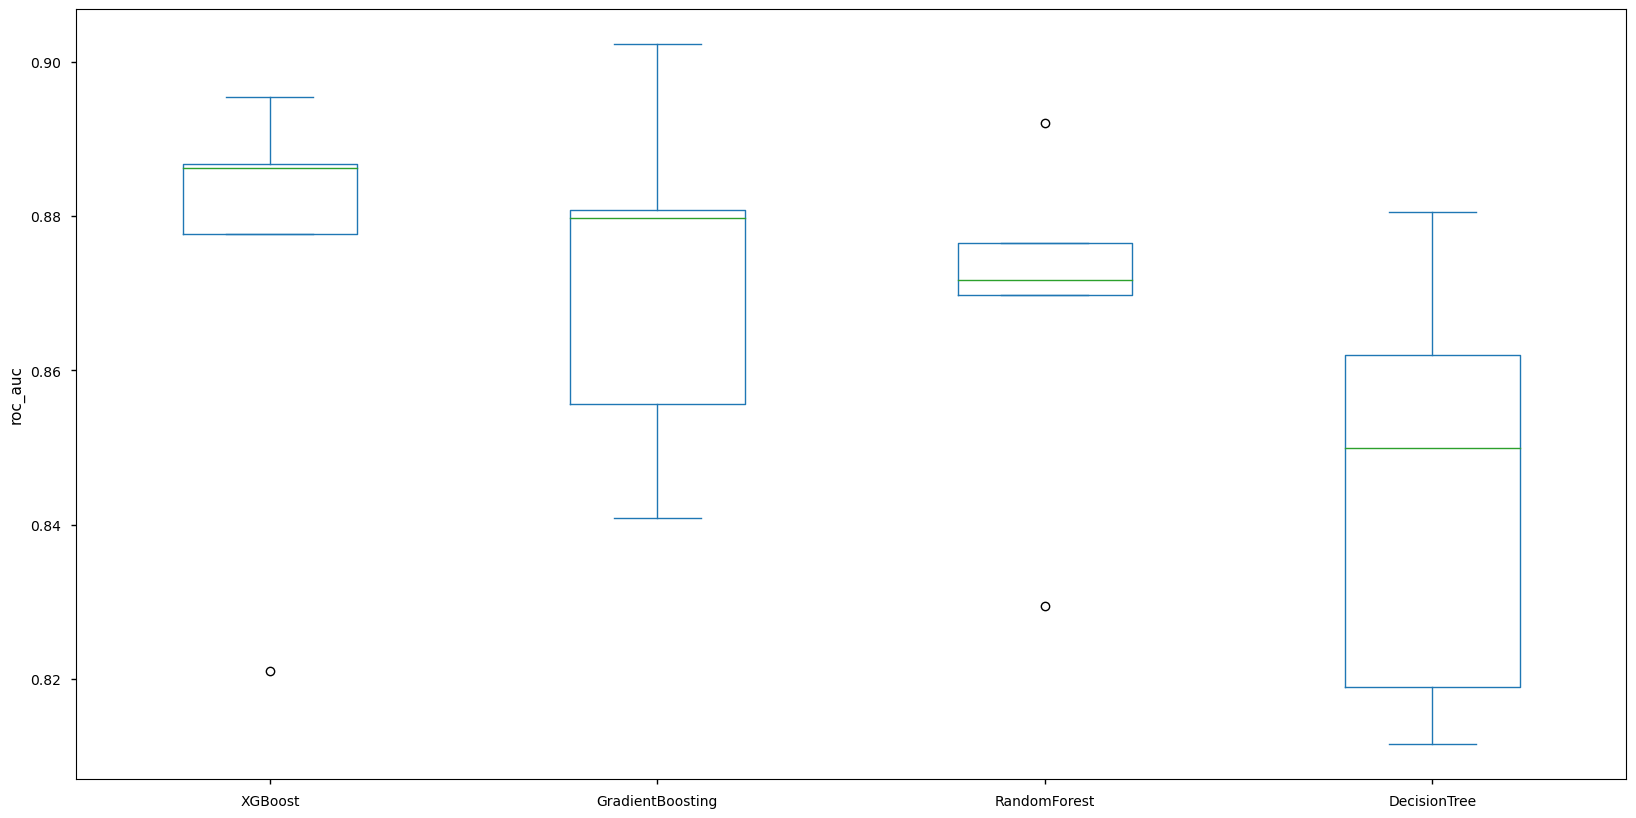

In [45]:
# Boxplot de los scores en test del mejor modelo de cada tipo
df_best.index = df_best['clf']
df_best[split_test_score_columns].T.plot(kind = 'box', figsize = (20, 10))
plt.ylabel("roc_auc")
plt.show()

In [46]:
for i, r in df_best.iterrows():
    print(r.clf, "=>", np.round(r.mean_test_score, 4), "\u00B1", np.round(r.std_test_score, 4))

XGBoost => 0.8734 ± 0.0268
GradientBoosting => 0.8719 ± 0.0214
RandomForest => 0.8679 ± 0.0208
DecisionTree => 0.8446 ± 0.026


In [47]:
# Escogemos el mejor modelo de todos 
best_model = best_estimators['XGBoost']
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=95, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [49]:
# Obtenemos su rendimiento (ROC AUC) sobre los datos de test 
y_pred = best_model.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred)

0.8702968425033087